In [7]:
# set up the python
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
import cftime
import IPython.display
import sys, os, warnings
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.ticker as mticker

In [8]:
session = cc.database.create_session()

In [9]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36489/status,
Dashboard: /proxy/36489/status,Workers: 7
Total threads: 28,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36015,Workers: 7
Dashboard: /proxy/36489/status,Total threads: 28
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:40841,Total threads: 4
Dashboard: /proxy/34171/status,Memory: 28.57 GiB
Nanny: tcp://127.0.0.1:36829,


In [10]:
# time period
start_time = '2010-01-01'
end_time = '2011-01-01'

In [14]:
# load the data
d_lon_t = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='dxt', 
                          session=session, frequency='static', n=1)
d_lat_t = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='dyt', 
                          session=session, frequency='static', n=1)
trans_y = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='ty_trans_rho', 
                          session=session, frequency='1 monthly',
                          start_time='1958-01-31 00:00:00', 
                          end_time='2018-12-31 00:00:00').sel(time = slice(start_time,end_time))
trans_x = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='tx_trans_rho', 
                          session=session, frequency='1 monthly',
                          start_time='1958-01-31 00:00:00', 
                          end_time='2018-12-31 00:00:00').sel(time = slice(start_time,end_time))
d_lon_u = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='dxu', 
                          session=session, frequency='static', n=1)
d_lat_u = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='dyu', 
                          session=session, frequency='static', n=1)

In [250]:
# convert transport to 2d
# select an circulation domin without divergent
trans_x_c = (trans_x.sel(grid_xu_ocean = slice(-265,-255)).sel(grid_yt_ocean = slice(-63,-60)).mean('time').sum('potrho')/1035).load()
trans_y_c = (trans_y.sel(grid_xt_ocean = slice(-265,-255)).sel(grid_yu_ocean = slice(-63,-60)).mean('time').sum('potrho')/1035).load()
# select a divergent domin
trans_x_d = (trans_x.sel(grid_xu_ocean = slice(-5,0)).sel(grid_yt_ocean = slice(-69,-67.5)).mean('time').sum('potrho')/1035).load()
trans_y_d = (trans_y.sel(grid_xt_ocean = slice(-5,0)).sel(grid_yu_ocean = slice(-69,-67.5)).mean('time').sum('potrho')/1035).load()

In [251]:
# dlon and dlat
# circulation
d_lon_t_c = d_lon_t.sel(xt_ocean = slice(-265,-255)).sel(yt_ocean = slice(-63,-60))
d_lat_t_c = d_lat_t.sel(xt_ocean = slice(-265,-255)).sel(yt_ocean = slice(-63,-60))
d_lon_u_c = d_lon_u.sel(xu_ocean = slice(-265,-255)).sel(yu_ocean = slice(-63,-60))
d_lat_u_c = d_lat_u.sel(xu_ocean = slice(-265,-255)).sel(yu_ocean = slice(-63,-60))
# divergent
d_lon_t_d = d_lon_t.sel(xt_ocean = slice(-5,0)).sel(yt_ocean = slice(-69,-67.5))
d_lat_t_d = d_lat_t.sel(xt_ocean = slice(-5,0)).sel(yt_ocean = slice(-69,-67.5))
d_lon_u_d = d_lon_u.sel(xu_ocean = slice(-5,0)).sel(yu_ocean = slice(-69,-67.5))
d_lat_u_d = d_lat_u.sel(xu_ocean = slice(-5,0)).sel(yu_ocean = slice(-69,-67.5))

In [252]:
# setup y coordinate
# circulation
grid_yt_ocean_c = trans_x_c.grid_yt_ocean
grid_yu_ocean_c = trans_y_c.grid_yu_ocean
yt_ocean_c = d_lon_t_c.yt_ocean
yu_ocean_c = d_lon_u_c.yu_ocean
# divergent
grid_yt_ocean_d = trans_x_d.grid_yt_ocean
grid_yu_ocean_d = trans_y_d.grid_yu_ocean
yt_ocean_d = d_lon_t_d.yt_ocean
yu_ocean_d = d_lon_u_d.yu_ocean

In [253]:
# setup x coordinate
# circulation
grid_xu_ocean_c = trans_x_c.grid_xu_ocean
grid_xt_ocean_c = trans_y_c.grid_xt_ocean
xt_ocean_c = d_lon_t_c.xt_ocean
xu_ocean_c = d_lon_u_c.xu_ocean
# divergent
grid_xu_ocean_d = trans_x_d.grid_xu_ocean
grid_xt_ocean_d = trans_y_d.grid_xt_ocean
xt_ocean_d = d_lon_t_d.xt_ocean
xu_ocean_d = d_lon_u_d.xu_ocean

# first, we calculate the circulation domin

In [20]:
trans_x_c

<xarray.DataArray 'tx_trans_rho' (grid_yt_ocean: 62, grid_xu_ocean: 100)>
array([[-277805.4  , -235401.47 , -188241.58 , ..., -230254.72 ,
        -267806.56 , -303840.97 ],
       [-261819.23 , -205150.98 , -158006.84 , ..., -259839.66 ,
        -235546.17 , -210472.44 ],
       [-229633.94 , -187935.9  , -157905.31 , ..., -259248.25 ,
        -164846.36 ,  -77809.875],
       ...,
       [ 900988.8  ,  904980.4  ,  931837.6  , ...,  318022.9  ,
         325166.88 ,  315178.7  ],
       [1126609.8  , 1133387.4  , 1140609.1  , ...,  287369.56 ,
         317841.66 ,  307264.7  ],
       [1300710.4  , 1312244.1  , 1312293.9  , ...,  182016.28 ,
         247480.78 ,  298765.   ]], dtype=float32)
Coordinates:
  * grid_xu_ocean  (grid_xu_ocean) float64 -265.0 -264.9 ... -255.2 -255.1
  * grid_yt_ocean  (grid_yt_ocean) float64 -62.96 -62.91 -62.86 ... -60.1 -60.05

In [21]:
trans_y_c

<xarray.DataArray 'ty_trans_rho' (grid_yu_ocean: 63, grid_xt_ocean: 100)>
array([[-103896.25  , -191464.98  , -262425.8   , ...,  720189.06  ,
         572302.    ,  340570.9   ],
       [-146299.17  , -238623.86  , -276659.8   , ...,  757741.4   ,
         608336.9   ,  392883.75  ],
       [-202966.5   , -285766.88  , -284217.    , ...,  733448.56  ,
         583263.75  ,  368126.6   ],
       ...,
       [ 762665.6   ,  871548.06  ,  946155.9   , ...,  -10377.44  ,
          -8973.142 ,  -30632.818 ],
       [ 755889.4   ,  864327.7   ,  936494.1   , ...,  -40848.99  ,
           1604.3746,  -41447.023 ],
       [ 744356.9   ,  864279.4   ,  922249.    , ..., -106313.    ,
         -49679.32  ,  -66476.64  ]], dtype=float32)
Coordinates:
  * grid_xt_ocean  (grid_xt_ocean) float64 -264.9 -264.8 ... -255.1 -255.0
  * grid_yu_ocean  (grid_yu_ocean) float64 -62.98 -62.93 ... -60.07 -60.02

In [26]:
d_lon_u_c

<xarray.DataArray 'dxu' (yu_ocean: 63, xu_ocean: 100)>
dask.array<getitem, shape=(63, 100), dtype=float32, chunksize=(63, 100), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -265.0 -264.9 -264.8 ... -255.3 -255.2 -255.1
  * yu_ocean  (yu_ocean) float64 -62.98 -62.93 -62.89 ... -60.12 -60.07 -60.02
Attributes:
    long_name:     ocean dxu on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_c geolat_c
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-11-11
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

In [27]:
d_lat_t_c

<xarray.DataArray 'dyt' (yt_ocean: 62, xt_ocean: 100)>
dask.array<getitem, shape=(62, 100), dtype=float32, chunksize=(62, 100), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -264.9 -264.8 -264.7 ... -255.2 -255.1 -255.0
  * yt_ocean  (yt_ocean) float64 -62.96 -62.91 -62.86 ... -60.15 -60.1 -60.05
Attributes:
    long_name:     ocean dyt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-11-11
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

To make the cell cnsistent with u and v, dx and dy, we should set u(yt_ocean, xu_ocean) as the reference coordinate

du/dx = (u(i+1,j) - u(i,j))/dx(i,j)

dv/dy = (v(i,j+1)-v(i,j))/dy(i,j)

In [39]:
dy = d_lat_t_c[:61,:].values
dx = d_lon_u_c[:62,:99].values
u = trans_x_c.values
v = trans_y_c[:62,:].values

In [40]:
dy.shape

(61, 100)

In [34]:
dx.shape

(62, 99)

In [31]:
v.shape

(62, 100)

In [32]:
u.shape

(62, 100)

In [42]:
fxy = np.zeros((61,99))

In [44]:
# now compute the fxy
# use the loop to resolvee the equation
for i in range(61):
    for j in range(99):
        fxy[i,j] = (u[i,j+1]-u[i,j])/(dx[i,j]) + ((v[i+1,j]-v[i,j]))/(dy[i,j])

In [46]:
yt_ocean_c

<xarray.DataArray 'yt_ocean' (yt_ocean: 62)>
array([-62.95505 , -62.909546, -62.863971, -62.818325, -62.772608, -62.72682 ,
       -62.680961, -62.635031, -62.58903 , -62.542957, -62.496813, -62.450598,
       -62.404311, -62.357952, -62.311521, -62.265019, -62.218445, -62.171799,
       -62.125081, -62.07829 , -62.031428, -61.984493, -61.937485, -61.890406,
       -61.843254, -61.796029, -61.748731, -61.701361, -61.653918, -61.606402,
       -61.558813, -61.51115 , -61.463415, -61.415606, -61.367724, -61.319769,
       -61.27174 , -61.223638, -61.175462, -61.127212, -61.078889, -61.030491,
       -60.98202 , -60.933474, -60.884855, -60.836161, -60.787393, -60.738551,
       -60.689634, -60.640643, -60.591577, -60.542436, -60.493221, -60.443931,
       -60.394566, -60.345126, -60.295611, -60.246021, -60.196356, -60.146615,
       -60.096799, -60.046908])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -62.96 -62.91 -62.86 ... -60.15 -60.1 -60.05
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y

In [47]:
xu_ocean_c

<xarray.DataArray 'xu_ocean' (xu_ocean: 100)>
array([-265. , -264.9, -264.8, -264.7, -264.6, -264.5, -264.4, -264.3, -264.2,
       -264.1, -264. , -263.9, -263.8, -263.7, -263.6, -263.5, -263.4, -263.3,
       -263.2, -263.1, -263. , -262.9, -262.8, -262.7, -262.6, -262.5, -262.4,
       -262.3, -262.2, -262.1, -262. , -261.9, -261.8, -261.7, -261.6, -261.5,
       -261.4, -261.3, -261.2, -261.1, -261. , -260.9, -260.8, -260.7, -260.6,
       -260.5, -260.4, -260.3, -260.2, -260.1, -260. , -259.9, -259.8, -259.7,
       -259.6, -259.5, -259.4, -259.3, -259.2, -259.1, -259. , -258.9, -258.8,
       -258.7, -258.6, -258.5, -258.4, -258.3, -258.2, -258.1, -258. , -257.9,
       -257.8, -257.7, -257.6, -257.5, -257.4, -257.3, -257.2, -257.1, -257. ,
       -256.9, -256.8, -256.7, -256.6, -256.5, -256.4, -256.3, -256.2, -256.1,
       -256. , -255.9, -255.8, -255.7, -255.6, -255.5, -255.4, -255.3, -255.2,
       -255.1])
Coordinates:
  * xu_ocean  (xu_ocean) float64 -265.0 -264.9 -264.8 ... -255.3 -255.2 -255.1
Attributes:
    long_name:       ucell longitude
    units:           degrees_E
    cartesian_axis:  X

In [49]:
source = xr.DataArray(fxy, dims = ['yt_ocean','xu_ocean'], coords = [yt_ocean_c[:61],xu_ocean_c[:99]])

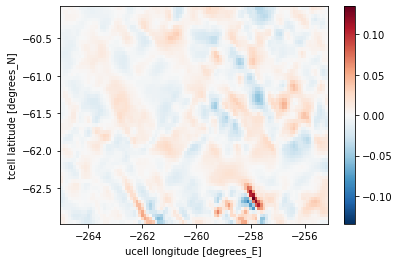

In [52]:
source.plot()

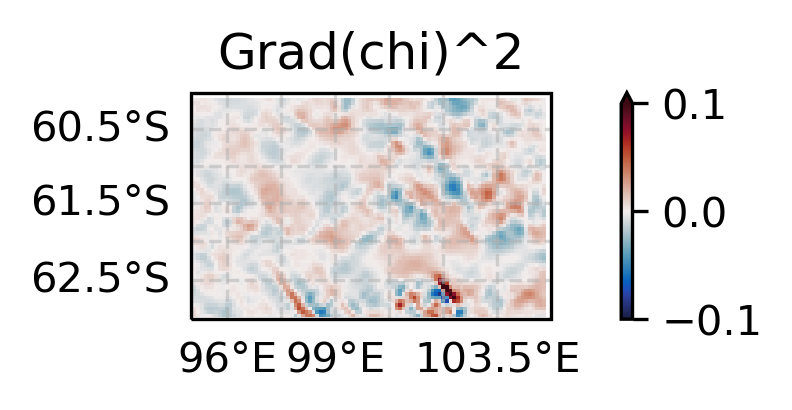

In [53]:
# 
projection=ccrs.Mercator(min_latitude=-65.0, max_latitude=-60.0)
#projection=ccrs.Stereographic(central_latitude=-72, central_longitude=120)
fig = plt.figure(figsize=(6, 1), dpi=300)
ax = plt.subplot(1, 1, 1, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-265,-255, -63, -60], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
lb.xlabels_top = False
lb.ylabels_right = False
#lb.ylocator = mticker.FixedLocator([-65, -60,-55])
p1 = source.plot(ax =ax, vmin = -0.1,vmax=0.1, transform=ccrs.PlateCarree(),cmap=cm.cm.balance)
ax.coastlines(resolution='50m')
ax.set_title('Grad(chi)^2')
ax. grid(False)

In [54]:
source

<xarray.DataArray (yt_ocean: 61, xu_ocean: 99)>
array([[ 6.71958923e-03,  7.45105743e-03,  2.40802765e-03, ...,
        -5.07068634e-03, -5.68008423e-03, -5.44691086e-03],
       [ 8.87680054e-03,  7.45582581e-03,  1.35719776e-03, ...,
         3.33452225e-03,  3.85999680e-03,  3.96776199e-03],
       [ 6.57653809e-03,  4.79602814e-03,  1.59430504e-03, ...,
         1.29966736e-02,  1.46217346e-02,  1.34925842e-02],
       ...,
       [-8.19861889e-05,  1.54769421e-03,  4.34875488e-03, ...,
        -1.10387802e-03, -3.73554230e-03, -4.43339348e-04],
       [ 7.71701336e-04,  3.94392014e-03,  4.03308868e-03, ...,
         2.31862068e-03,  1.07216835e-03, -1.26552582e-03],
       [ 1.17301941e-03,  1.23369694e-03,  1.58941746e-03, ...,
         8.15773010e-03,  4.25720215e-03, -1.34468079e-03]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -62.96 -62.91 -62.86 ... -60.2 -60.15 -60.1
  * xu_ocean  (xu_ocean) float64 -265.0 -264.9 -264.8 ... -255.4 -255.3 -255.2

In [55]:
dx.shape

(62, 99)

In [79]:
dy.shape

(61, 100)

Now resolve chi

In [87]:
chi_1 = np.zeros((61,99))
chi = np.zeros((61,99))

In [88]:
for i in range(60):
    for j in range(97):
        chi_1 = chi.copy()
        chi[1:-1,1:-1] = ((dx[1:-2,1:-1])**2*(chi_1[1:-1,0:-2] + chi_1[1:-1,2:]) +
                      (dy[1:-1,1:-2])**2*(chi_1[0:-2,1:-1] + chi_1[2:,1:-1]) - 
                      fxy[1:-1,1:-1]*(dx[1:-2,1:-1])**2*(dy[1:-1,1:-2])**2)/(2*(dx[1:-2,1:-1])**2+2*(dy[1:-1,1:-2]**2))

In [89]:
chi

array([[       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [       0.        ,    41059.09585963,   202144.02464776, ...,
         -768223.36659357,  -449159.30747496,        0.        ],
       [       0.        ,   153162.86215989,   403335.96564214, ...,
        -1555800.18971841,  -929388.28366768,        0.        ],
       ...,
       [       0.        ,   -68617.2743782 ,  -125078.76782644, ...,
          179909.6054285 ,   137941.45106812,        0.        ],
       [       0.        ,   -73428.38171099,  -104384.40650461, ...,
           51742.50462553,    39231.52127685,        0.        ],
       [       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ]])

In [91]:
np.shape(chi)

(61, 99)

In [94]:
Chi = xr.DataArray(chi,dims = ['yt_ocean','xu_ocean'], coords = [yt_ocean_c[:61],xu_ocean_c[:99]])

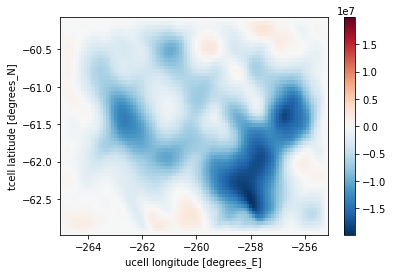

In [95]:
Chi.plot()

In [96]:
Chi

<xarray.DataArray (yt_ocean: 61, xu_ocean: 99)>
array([[       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [       0.        ,    41059.09585963,   202144.02464776, ...,
         -768223.36659357,  -449159.30747496,        0.        ],
       [       0.        ,   153162.86215989,   403335.96564214, ...,
        -1555800.18971841,  -929388.28366768,        0.        ],
       ...,
       [       0.        ,   -68617.2743782 ,  -125078.76782644, ...,
          179909.6054285 ,   137941.45106812,        0.        ],
       [       0.        ,   -73428.38171099,  -104384.40650461, ...,
           51742.50462553,    39231.52127685,        0.        ],
       [       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -62.96 -62.91 -62.86 ... -60.2 -60.15 -60.1
  * xu_ocean  (xu_ocean) float64 -265.0 -264.9 -264.8 ... -255.4 -255.3 -255.2

In [97]:
# now compute the dchi/dx
grad_chi_x = np.zeros((61,98))

In [98]:
dx = dx[:61,:98]

In [100]:
for i in range(98):
    grad_chi_x[:,i] = (chi[:,i+1]-chi[:,i])/(dx[:,i])

In [106]:
Grad_chi_x = xr.DataArray(grad_chi_x, dims = ['grid_yt_ocean','grid_xu_ocean'], coords = [trans_x_c.grid_yt_ocean[:61],trans_x_c.grid_xu_ocean[:98]])

In [107]:
Grad_chi_x

<xarray.DataArray (grid_yt_ocean: 61, grid_xu_ocean: 98)>
array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  8.11469013,  31.83592466,  38.90215977, ...,  42.32886313,
         63.05803668,  88.76933418],
       [ 30.22325395,  49.36604821,  59.91427951, ...,  75.394599  ,
        123.60833327, 183.39392275],
       ...,
       [-12.42497135, -10.22384589,  -1.89441073, ...,  -6.60705538,
         -7.59944373, -24.97794606],
       [-13.27602795,  -5.59692371,   1.58909585, ...,  -1.26672159,
         -2.26201587,  -7.09315337],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
  * grid_yt_ocean  (grid_yt_ocean) float64 -62.96 -62.91 -62.86 ... -60.15 -60.1
  * grid_xu_ocean  (grid_xu_ocean) float64 -265.0 -264.9 ... -255.4 -255.3

In [108]:
trans_x_c

<xarray.DataArray 'tx_trans_rho' (grid_yt_ocean: 62, grid_xu_ocean: 100)>
array([[-277805.4  , -235401.47 , -188241.58 , ..., -230254.72 ,
        -267806.56 , -303840.97 ],
       [-261819.23 , -205150.98 , -158006.84 , ..., -259839.66 ,
        -235546.17 , -210472.44 ],
       [-229633.94 , -187935.9  , -157905.31 , ..., -259248.25 ,
        -164846.36 ,  -77809.875],
       ...,
       [ 900988.8  ,  904980.4  ,  931837.6  , ...,  318022.9  ,
         325166.88 ,  315178.7  ],
       [1126609.8  , 1133387.4  , 1140609.1  , ...,  287369.56 ,
         317841.66 ,  307264.7  ],
       [1300710.4  , 1312244.1  , 1312293.9  , ...,  182016.28 ,
         247480.78 ,  298765.   ]], dtype=float32)
Coordinates:
  * grid_xu_ocean  (grid_xu_ocean) float64 -265.0 -264.9 ... -255.2 -255.1
  * grid_yt_ocean  (grid_yt_ocean) float64 -62.96 -62.91 -62.86 ... -60.1 -60.05

In [115]:
d_psi = (trans_x_c[:61,:98] - Grad_chi_x)/1e6

In [116]:
d_psi

<xarray.DataArray (grid_yt_ocean: 61, grid_xu_ocean: 98)>
array([[-0.27780541, -0.23540147, -0.18824158, ..., -0.19597523,
        -0.19670903, -0.23025472],
       [-0.26182735, -0.20518282, -0.15804575, ..., -0.30260989,
        -0.28087281, -0.25992843],
       [-0.22966416, -0.18798527, -0.15796523, ..., -0.38786921,
        -0.3431178 , -0.25943164],
       ...,
       [ 0.66311536,  0.66061666,  0.67000508, ...,  0.32725161,
         0.29152216,  0.28262957],
       [ 0.90100209,  0.90498597,  0.93183604, ...,  0.29476586,
         0.30186264,  0.31803   ],
       [ 1.12660975,  1.13338738,  1.14060912, ...,  0.15496883,
         0.22829147,  0.28736956]])
Coordinates:
  * grid_xu_ocean  (grid_xu_ocean) float64 -265.0 -264.9 ... -255.4 -255.3
  * grid_yt_ocean  (grid_yt_ocean) float64 -62.96 -62.91 -62.86 ... -60.15 -60.1

In [117]:
psi = d_psi.cumsum('grid_yt_ocean').load()

In [118]:
flux = (trans_x_c.cumsum('grid_yt_ocean')/1e6).load()

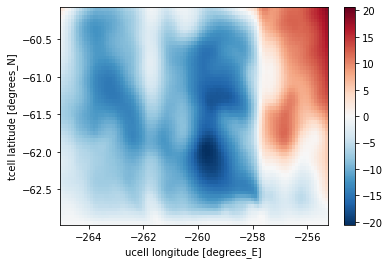

In [119]:
psi.plot()

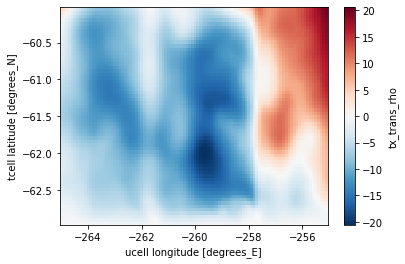

In [120]:
flux.plot()

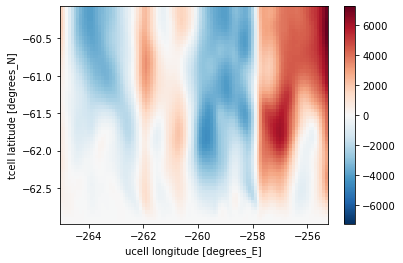

In [121]:
Grad_chi_x.cumsum('grid_yt_ocean').plot()

# Therefore, in a circulation domin, psi is very consistent with the barotropic streamfunction, what about in the divergent domin?

In [256]:
trans_x_d

<xarray.DataArray 'tx_trans_rho' (grid_yt_ocean: 36, grid_xu_ocean: 50)>
array([[-230148.97  , -236615.1   , -248541.67  , ..., -730655.    ,
        -667796.9   , -586122.4   ],
       [-190534.7   , -194330.22  , -216000.56  , ..., -631466.7   ,
        -577190.7   , -510986.8   ],
       [-193898.9   , -210569.92  , -237054.97  , ..., -394169.4   ,
        -407985.62  , -433513.2   ],
       ...,
       [-102659.01  , -103360.805 , -109142.79  , ...,    3621.8076,
          10084.895 ,   10230.976 ],
       [ -84298.734 ,  -79356.43  ,  -77561.414 , ...,   -3197.387 ,
          13656.73  ,   12600.325 ],
       [ -71302.52  ,  -70708.55  ,  -63990.21  , ...,  -21623.83  ,
          -7653.305 ,  -14205.29  ]], dtype=float32)
Coordinates:
  * grid_xu_ocean  (grid_xu_ocean) float64 -4.9 -4.8 -4.7 ... -0.1 -4.843e-12
  * grid_yt_ocean  (grid_yt_ocean) float64 -68.99 -68.94 -68.9 ... -67.55 -67.51

In [257]:
trans_y_d

<xarray.DataArray 'ty_trans_rho' (grid_yu_ocean: 35, grid_xt_ocean: 50)>
array([[142150.12  ,  97183.72  ,  65814.94  , ...,  80807.17  ,
         60563.516 ,  49091.312 ],
       [160458.69  , 100978.664 ,  87484.68  , ...,  42400.234 ,
          6287.5264, -17112.697 ],
       [170955.16  , 117649.14  , 113969.17  , ...,  22235.852 ,
         20103.648 ,   8414.78  ],
       ...,
       [-87387.625 , -84006.23  , -82625.195 , ...,   9369.792 ,
        -12881.463 , -41713.11  ],
       [-84121.63  , -83304.    , -76842.85  , ...,   6386.8584,
        -19344.162 , -41858.746 ],
       [-80381.914 , -88245.89  , -78637.445 , ..., -11509.366 ,
        -36197.996 , -40802.02  ]], dtype=float32)
Coordinates:
  * grid_xt_ocean  (grid_xt_ocean) float64 -4.95 -4.85 -4.75 ... -0.15 -0.05
  * grid_yu_ocean  (grid_yu_ocean) float64 -68.96 -68.92 ... -67.57 -67.53

In [258]:
d_lon_u_d

<xarray.DataArray 'dxu' (yu_ocean: 35, xu_ocean: 50)>
dask.array<getitem, shape=(35, 50), dtype=float32, chunksize=(35, 50), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -4.9 -4.8 -4.7 -4.6 ... -0.2 -0.1 -4.843e-12
  * yu_ocean  (yu_ocean) float64 -68.96 -68.92 -68.88 ... -67.61 -67.57 -67.53
Attributes:
    long_name:     ocean dxu on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_c geolat_c
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-11-11
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

In [259]:
d_lat_t_d

<xarray.DataArray 'dyt' (yt_ocean: 36, xt_ocean: 50)>
dask.array<getitem, shape=(36, 50), dtype=float32, chunksize=(36, 50), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -4.95 -4.85 -4.75 -4.65 ... -0.25 -0.15 -0.05
  * yt_ocean  (yt_ocean) float64 -68.99 -68.94 -68.9 ... -67.59 -67.55 -67.51
Attributes:
    long_name:     ocean dyt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-11-11
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Run configuration and history: https://github.com/COSIMA/0...

In [292]:
# set up the np arrays
dy = d_lat_t_d[:34,:].values
dx = d_lon_u_d[:35,:49].values
u = trans_x_d[:35,:].values
v = trans_y_d[:35,:].values

In [261]:
dy.shape

(34, 50)

In [262]:
dx.shape

(35, 49)

In [263]:
v.shape

(35, 50)

In [264]:
u.shape

(35, 50)

In [265]:
fxy = np.zeros((34,49))

In [266]:
# now compute the fxy
# use the loop to resolvee the equation
for i in range(33):
    for j in range(49):
        fxy[i,j] = (u[i,j+1]-u[i,j])/(dx[i,j]) + ((v[i+1,j]-v[i,j]))/(dy[i,j])

In [267]:
yt_ocean_d

<xarray.DataArray 'yt_ocean' (yt_ocean: 36)>
array([-68.985937, -68.943698, -68.901458, -68.859219, -68.81698 , -68.77474 ,
       -68.732501, -68.690261, -68.648022, -68.605783, -68.563543, -68.521304,
       -68.479065, -68.436825, -68.394586, -68.352347, -68.310107, -68.267868,
       -68.225629, -68.183389, -68.14115 , -68.098911, -68.056671, -68.014432,
       -67.972192, -67.929953, -67.887714, -67.845474, -67.803235, -67.760996,
       -67.718756, -67.676517, -67.634278, -67.592038, -67.549799, -67.50756 ])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -68.99 -68.94 -68.9 ... -67.59 -67.55 -67.51
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y

In [268]:
xu_ocean_d

<xarray.DataArray 'xu_ocean' (xu_ocean: 50)>
array([-4.900000e+00, -4.800000e+00, -4.700000e+00, -4.600000e+00,
       -4.500000e+00, -4.400000e+00, -4.300000e+00, -4.200000e+00,
       -4.100000e+00, -4.000000e+00, -3.900000e+00, -3.800000e+00,
       -3.700000e+00, -3.600000e+00, -3.500000e+00, -3.400000e+00,
       -3.300000e+00, -3.200000e+00, -3.100000e+00, -3.000000e+00,
       -2.900000e+00, -2.800000e+00, -2.700000e+00, -2.600000e+00,
       -2.500000e+00, -2.400000e+00, -2.300000e+00, -2.200000e+00,
       -2.100000e+00, -2.000000e+00, -1.900000e+00, -1.800000e+00,
       -1.700000e+00, -1.600000e+00, -1.500000e+00, -1.400000e+00,
       -1.300000e+00, -1.200000e+00, -1.100000e+00, -1.000000e+00,
       -9.000000e-01, -8.000000e-01, -7.000000e-01, -6.000000e-01,
       -5.000000e-01, -4.000000e-01, -3.000000e-01, -2.000000e-01,
       -1.000000e-01, -4.843376e-12])
Coordinates:
  * xu_ocean  (xu_ocean) float64 -4.9 -4.8 -4.7 -4.6 ... -0.2 -0.1 -4.843e-12
Attributes:
    long_name:       ucell longitude
    units:           degrees_E
    cartesian_axis:  X

In [269]:
source = xr.DataArray(fxy, dims = ['yt_ocean','xu_ocean'], coords = [yt_ocean_d[:34],xu_ocean_d[:49]])

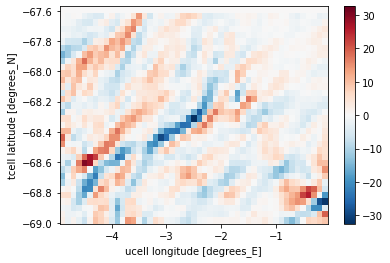

In [270]:
source.plot()

In [271]:
source

<xarray.DataArray (yt_ocean: 34, xu_ocean: 49)>
array([[  2.27801347,  -2.18020105,   1.36431241, ...,   6.31471825,
          7.57175446,   8.90747643],
       [  1.28567052,  -1.8697598 ,  -1.59897518, ...,  -4.71419334,
          9.27953815,  19.49715042],
       [ -1.04686546,  -1.60076904,  -5.44605827, ..., -20.33856773,
        -20.43693733,  -3.7216866 ],
       ...,
       [ -0.30877849,  -0.67654908,  -1.14021587, ...,  -1.42334461,
         -1.31059003,   1.37472486],
       [  0.2451641 ,  -0.6490168 ,   0.48090607, ...,  -0.4297803 ,
         -2.48484921,  -1.5328896 ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -68.99 -68.94 -68.9 ... -67.68 -67.63 -67.59
  * xu_ocean  (xu_ocean) float64 -4.9 -4.8 -4.7 -4.6 ... -0.4 -0.3 -0.2 -0.1

In [291]:
dx.shape

(33, 48)

In [273]:
dy.shape

(34, 50)

In [274]:
chi_1 = np.zeros((34,49))
chi = np.zeros((34,49))

In [275]:
for i in range(33):
    for j in range(47):
        chi_1 = chi.copy()
        chi[1:-1,1:-1] = ((dx[1:-2,1:-1])**2*(chi_1[1:-1,0:-2] + chi_1[1:-1,2:]) +
                      (dy[1:-1,1:-2])**2*(chi_1[0:-2,1:-1] + chi_1[2:,1:-1]) - 
                      fxy[1:-1,1:-1]*(dx[1:-2,1:-1])**2*(dy[1:-1,1:-2])**2)/(2*(dx[1:-2,1:-1])**2+2*(dy[1:-1,1:-2]**2))

In [276]:
chi

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.21417337e+07, 9.29572665e+07, ...,
        4.97930981e+07, 1.17499431e+07, 0.00000000e+00],
       [0.00000000e+00, 8.25944269e+07, 1.79708595e+08, ...,
        9.01730069e+07, 1.52830821e+08, 0.00000000e+00],
       ...,
       [0.00000000e+00, 2.14456301e+07, 3.04075412e+07, ...,
        1.60012726e+07, 8.83140739e+06, 0.00000000e+00],
       [0.00000000e+00, 1.18604617e+07, 1.22026179e+07, ...,
        1.44496215e+07, 1.79657613e+07, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [277]:
np.shape(chi)

(34, 49)

In [279]:
Chi = xr.DataArray(chi,dims = ['yt_ocean','xu_ocean'], coords = [yt_ocean_d[:34],xu_ocean_d[:49]])

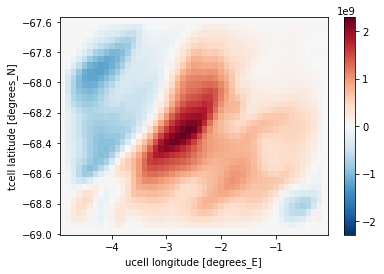

In [280]:
Chi.plot()

In [284]:
# now compute the dchi/dx
grad_chi_x = np.zeros((34,48))

In [293]:
dx = dx[:34,:48]

In [294]:
for i in range(48):
    grad_chi_x[:,i] = (chi[:,i+1]-chi[:,i])/(dx[:,i])

In [295]:
Grad_chi_x = xr.DataArray(grad_chi_x, dims = ['grid_yt_ocean','grid_xu_ocean'], coords = [trans_x_d.grid_yt_ocean[:34],trans_x_d.grid_xu_ocean[:48]])
Grad_chi_x

<xarray.DataArray (grid_yt_ocean: 34, grid_xu_ocean: 48)>
array([[     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ],
       [ 13039.0401651 ,  10206.70649216,   3526.99927029, ...,
         13245.00284165,  -9513.42028201,  -2938.29853048],
       [ 20614.89362756,  24238.90240884,   9589.43592107, ...,
         51169.74769664,  15638.87814451, -38145.32337801],
       ...,
       [  5073.04587189,   2119.97434385,    532.65364798, ...,
         -2223.49793112,  -1696.05905509,  -2089.10321139],
       [  2800.61549427,     80.79348319,    842.67962977, ...,
          -677.28260622,    830.26748106,  -4242.26230017],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])
Coordinates:
  * grid_yt_ocean  (grid_yt_ocean) float64 -68.99 -68.94 -68.9 ... -67.63 -67.59
  * grid_xu_ocean  (grid_xu_ocean) float64 -4.9 -4.8 -4.7 ... -0.4 -0.3 -0.2

In [296]:
trans_x_d

<xarray.DataArray 'tx_trans_rho' (grid_yt_ocean: 36, grid_xu_ocean: 50)>
array([[-230148.97  , -236615.1   , -248541.67  , ..., -730655.    ,
        -667796.9   , -586122.4   ],
       [-190534.7   , -194330.22  , -216000.56  , ..., -631466.7   ,
        -577190.7   , -510986.8   ],
       [-193898.9   , -210569.92  , -237054.97  , ..., -394169.4   ,
        -407985.62  , -433513.2   ],
       ...,
       [-102659.01  , -103360.805 , -109142.79  , ...,    3621.8076,
          10084.895 ,   10230.976 ],
       [ -84298.734 ,  -79356.43  ,  -77561.414 , ...,   -3197.387 ,
          13656.73  ,   12600.325 ],
       [ -71302.52  ,  -70708.55  ,  -63990.21  , ...,  -21623.83  ,
          -7653.305 ,  -14205.29  ]], dtype=float32)
Coordinates:
  * grid_xu_ocean  (grid_xu_ocean) float64 -4.9 -4.8 -4.7 ... -0.1 -4.843e-12
  * grid_yt_ocean  (grid_yt_ocean) float64 -68.99 -68.94 -68.9 ... -67.55 -67.51

In [297]:
d_psi = (trans_x_d[:61,:98] - Grad_chi_x)/1e6

In [298]:
d_psi


<xarray.DataArray (grid_yt_ocean: 34, grid_xu_ocean: 48)>
array([[-2.30148969e-01, -2.36615094e-01, -2.48541672e-01, ...,
        -8.52388250e-01, -7.95282000e-01, -7.30655000e-01],
       [-2.03573743e-01, -2.04536925e-01, -2.19527562e-01, ...,
        -7.29511128e-01, -6.60360080e-01, -6.28528389e-01],
       [-2.14513800e-01, -2.34808824e-01, -2.46644405e-01, ...,
        -5.32754935e-01, -4.29972722e-01, -3.56024083e-01],
       ...,
       [-1.38294468e-01, -1.38619006e-01, -1.41608107e-01, ...,
        -1.91491681e-02, -2.68534429e-02, -3.52157796e-02],
       [-1.24672248e-01, -1.23859004e-01, -1.28002617e-01, ...,
        -3.74050890e-03, -8.29015273e-03, -7.77626797e-03],
       [-1.02659008e-01, -1.03360805e-01, -1.09142789e-01, ...,
         3.67535376e-03,  6.38504883e-04,  3.62180762e-03]])
Coordinates:
  * grid_yt_ocean  (grid_yt_ocean) float64 -68.99 -68.94 -68.9 ... -67.63 -67.59
  * grid_xu_ocean  (grid_xu_ocean) float64 -4.9 -4.8 -4.7 ... -0.4 -0.3 -0.2

In [299]:
psi = d_psi.cumsum('grid_yt_ocean').load()

In [300]:
flux = (trans_x_d.cumsum('grid_yt_ocean')/1e6).load()

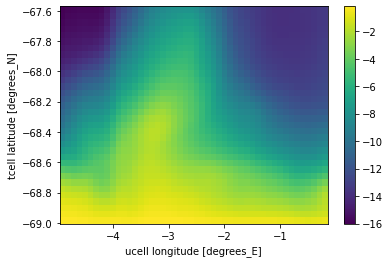

In [301]:
psi.plot()

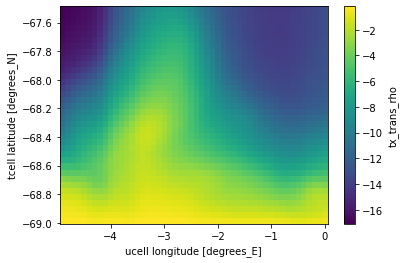

In [302]:
flux.plot()